In [20]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
files = {
    'epicurious':  '../data/raw/recipes_raw_nosource_epi.json',
    'foodnetwork': '../data/raw/recipes_raw_nosource_fn.json',
    'allrecipes':  '../data/raw/recipes_raw_nosource_ar.json',
}

rows = []
for source, path in files.items():
    with open(path) as f:
        data = json.load(f)
    for recipe in data.values():
        rows.append({
            'source':       source,
            'title':        (recipe.get('title') or '').strip(),
            'instructions': (recipe.get('instructions') or '').strip(),
            'ingredients':  recipe.get('ingredients') or [],
        })

df = pd.DataFrame(rows)
print(f'total recipes: {len(df)}')

total recipes: 125164


In [22]:
df['is_valid'] = (
    df['title'].str.len().gt(0) &
    df['instructions'].str.len().gt(0) &
    df['ingredients'].apply(len).ge(2)
)

print(f'valid:   {df["is_valid"].sum()}')
print(f'invalid: {(~df["is_valid"]).sum()}')
print(df.groupby('source')['is_valid'].value_counts())

valid:   122755
invalid: 2409
source       is_valid
allrecipes   True        39522
             False         280
epicurious   True        25211
             False         112
foodnetwork  True        58022
             False        2017
Name: count, dtype: int64


In [23]:
df_valid = df[df['is_valid']].copy()

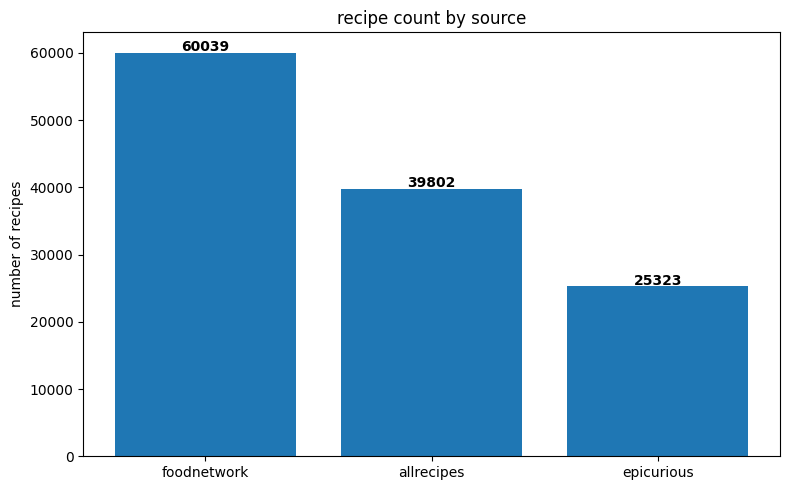

In [24]:
source_counts = df['source'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(source_counts.index, source_counts.values)
plt.title('recipe count by source')
plt.ylabel('number of recipes')
for i, v in enumerate(source_counts.values):
    plt.text(i, v + 200, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('recipe_count_by_source.png', dpi=150)
plt.show()

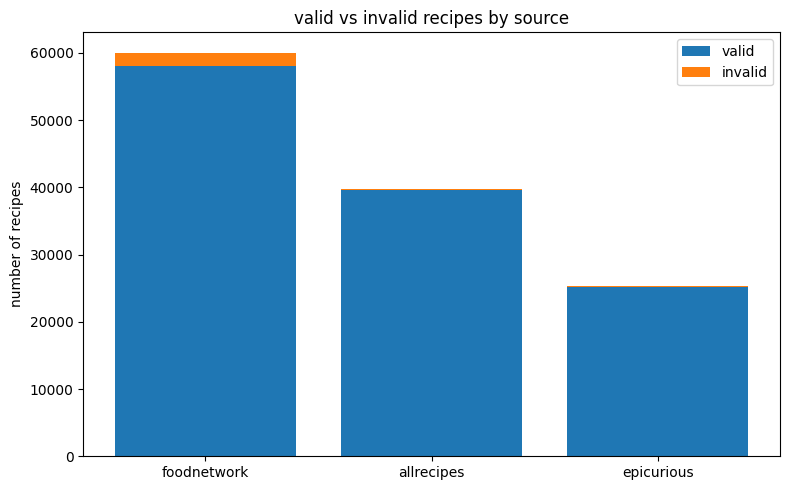

In [25]:
valid_counts   = df[df['is_valid']]['source'].value_counts()
invalid_counts = df[~df['is_valid']]['source'].value_counts().reindex(valid_counts.index, fill_value=0)

plt.figure(figsize=(8, 5))
plt.bar(valid_counts.index, valid_counts.values, label='valid')
plt.bar(invalid_counts.index, invalid_counts.values, bottom=valid_counts.values, label='invalid')
plt.title('valid vs invalid recipes by source')
plt.ylabel('number of recipes')
plt.legend()
plt.tight_layout()
plt.savefig('valid_vs_invalid.png', dpi=150)
plt.show()

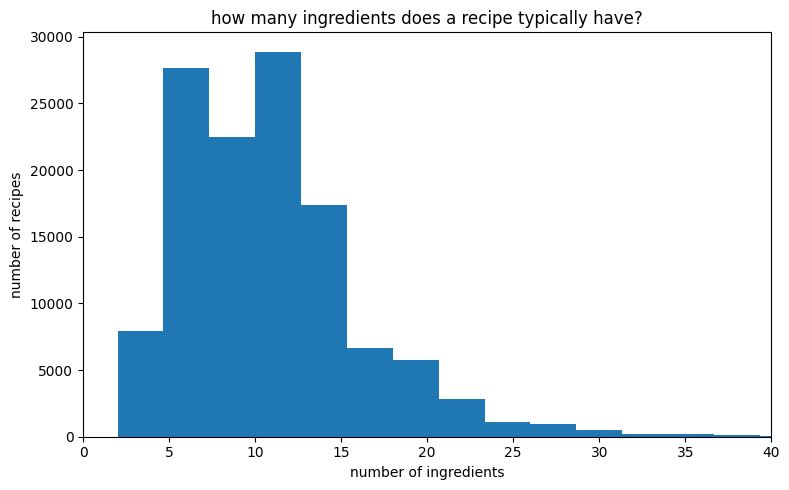

count    122755.00
mean         10.72
std           5.30
min           2.00
25%           7.00
50%          10.00
75%          13.00
max          82.00
Name: ingredient_count, dtype: float64


In [26]:
df_valid['ingredient_count'] = df_valid['ingredients'].apply(len)

plt.figure(figsize=(8, 5))
plt.hist(df_valid['ingredient_count'], bins=30)
plt.title('how many ingredients does a recipe typically have?')
plt.xlabel('number of ingredients')
plt.ylabel('number of recipes')
plt.xlim(0, 40)
plt.tight_layout()
plt.savefig('ingredient_count_distribution.png', dpi=150)
plt.show()

print(df_valid['ingredient_count'].describe().round(2))

In [27]:
for source in df_valid['source'].unique():
    subset = df_valid[df_valid['source'] == source]
    affected = subset['ingredients'].apply(
        lambda ingredients: any('advertisement' in i.lower() for i in ingredients)
    )
    print(f'{source}: {affected.sum()} recipes ({affected.mean()*100:.1f}%)')

epicurious: 0 recipes (0.0%)
foodnetwork: 0 recipes (0.0%)
allrecipes: 39518 recipes (100.0%)


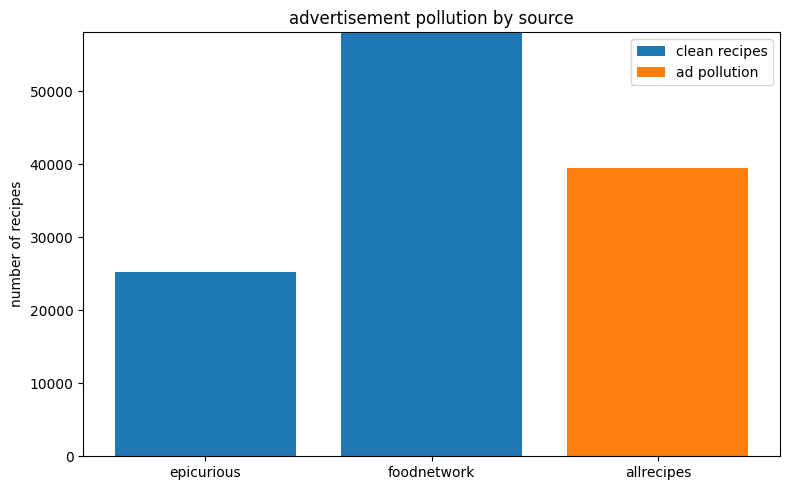

In [28]:
sources  = ['epicurious', 'foodnetwork', 'allrecipes']
affected = [0, 0, 39518]
total    = [25211, 58033, 39522]
clean    = [t - a for t, a in zip(total, affected)]

plt.figure(figsize=(8, 5))
plt.bar(sources, clean, label='clean recipes')
plt.bar(sources, affected, bottom=clean, label='ad pollution')
plt.title('advertisement pollution by source')
plt.ylabel('number of recipes')
plt.legend()
plt.tight_layout()
plt.savefig('ad_pollution.png', dpi=150)
plt.show()

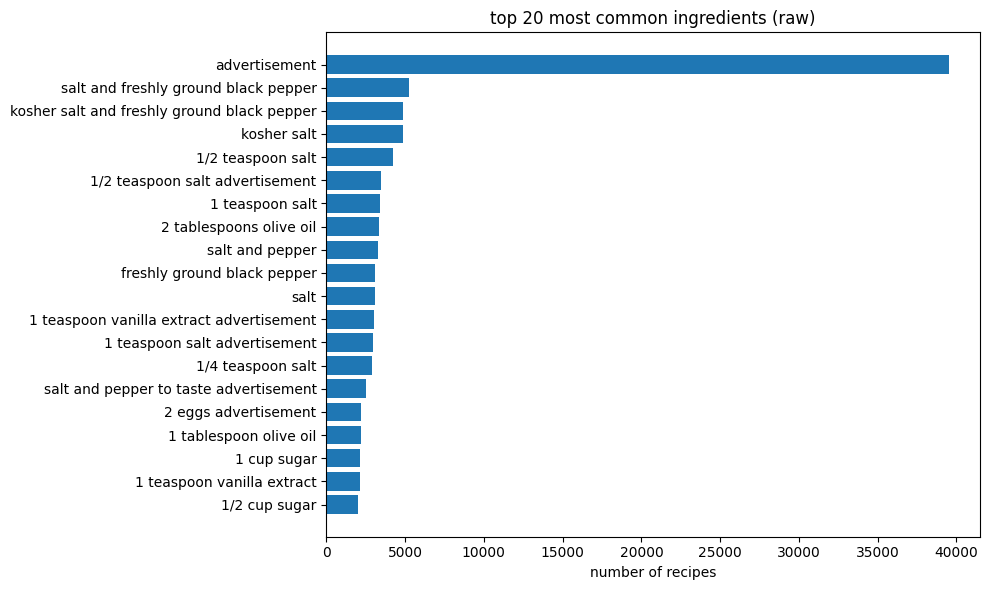

In [29]:
all_ingredients = []
for ingredients in df_valid['ingredients']:
    for ing in ingredients:
        all_ingredients.append(ing.strip().lower())

ingredient_counts = pd.Series(all_ingredients).value_counts()
top_20 = ingredient_counts.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20.index[::-1], top_20.values[::-1])
plt.title('top 20 most common ingredients (raw)')
plt.xlabel('number of recipes')
plt.tight_layout()
plt.savefig('top_ingredients.png', dpi=150)
plt.show()